### Facsimile inversion 

In [281]:
import numpy as np
import itertools as it
import sys
sys.path.append('../Comm/')
from utils import iterative_solve_eta as itsol
from utils import iterative_solve_Q as itsolQ
from utils import create_random_Q0
import matplotlib.pyplot as plt
from scipy.special import softmax

## Solve eta $\eta$

The value of $\eta$ is obtained by solving the following equation:
$$
\eta = \left( 1 - \gamma T \right)^{-1} \rho
$$

Where $\rho$ is given by the process and $T$ is building as follows:
$$
T(s',m'|s,m) = \sum_{a,y}\, p(s'|s,a)\, \pi(a,m'|m,y)\, f(y|s)
$$

In [295]:
clip = lambda x, l, u: l if x < l else u if x > u else x

def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range):
    """
    This function should solve the following:
    --> New_eta = (1 - gamma T)^-1 rho
    """
    
    O, M, A = pi.shape
    L = Lx * Ly
    new_eta = np.zeros(M*L)
    
    # PY has size ~ 10^5
    PY = PObs_lim.reshape(O, M, Ly, Lx)
    # PY has size ~ 10^2
    PAMU = pi.reshape(O, M, M, A//M)
    
    p_a_mu_m_xy = np.einsum( 'omyx, omna -> anmyx', PY, PAMU)
    # T [ s'm'  sm] = sum_a, mu p(s'm' | sm a mu) p(a mu | sm)
    #               = sum_a, mu p(s'm' | sm a mu) sum_y f(y | s) pi(a mu | y m)
    
    print(p_a_mu_m_xy.shape)
    
    # Tsm_sm has size ~ 10^5 x 10^5 or more
    Tsm_sm = np.zeros( (M, Ly, Lx, M, Ly, Lx) )
    
    # Action Order
    # left, right, up, down
    
    # tuples to be populated
    #      T indices : "left / right / up / down"
    #      (m', y', x', m, y, x)
    #      pi indices : "left_act / ... "
    #      (m', a, m, y, x)
    for im_new in range(M):
        
        left = [ (im_new, iy, clip(ix-1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for l, la in zip(left, left_act):
            Tsm_sm[l] += p_a_mu_m_xy[la]
        
        right = [ (im_new, iy, clip(ix+1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for r, ra in zip(right, right_act):
            Tsm_sm[r] += p_a_mu_m_xy[ra]
    
        up = [ (im_new, clip(iy+1, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for u, ua in zip(up, up_act):
            Tsm_sm[u] += p_a_mu_m_xy[ua]
        
        down = [ (im_new, clip(iy-1, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for d, da in zip(down, down_act):
            Tsm_sm[d] += p_a_mu_m_xy[da]
    
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    
    All = slice(None)
    for yx_found in yx_founds:
        ls = (All, yx_found[0], yx_found[1], All, All, All)
        # all transitions starting from the source do not go anywhere
        Tsm_sm[ls] = 0
        # all transitions ending in the source stop the episode
        ls = (All, All, All, All, yx_found[0], yx_found[1])
        Tsm_sm[ls] = 0
    
    Tsm_sm_matrix = np.reshape(Tsm_sm, (M*Ly*Lx, M*Ly*Lx))
    to_invert = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    inverted = np.linalg.inv(to_invert)
    new_eta = inverted @ rho0
    
    return new_eta, Tsm_sm_matrix

## Solve Q 
The value of $Q$ is the following:
$$
Q(s,m,a,m')= \sum_{s'}\, p(s'|s,a)\, \mathbb{1}(s'\neq x_s)\,(\gamma V(s',m')-1\,)
$$

First we need to find $V$ solving the linear system:
$$
\begin{align*}
V^{T} &= r^{T}(1-\gamma T)^{-1} \\
V^{T}(1-\gamma T)  &= r^{T} \\
(1-\gamma T^{T})V  &= r \\
\end{align*}
$$
Where $r$ is the reward vector, $T$ is the transition matrix and $\gamma$ is the discount factor.

The reward vector is:
$$
r(s,m) = -(1-\gamma) \sum_{a,s',y}\, p(s'|s,a)\, f(y|s) \, \pi_\theta (a,m'|m,y)\, \mathbb{1}(x'\neq x_s) 
$$


## Questions:
Why in the paper the T matrix looks like same for solve Q and eta?

Why the average rewards from Fortran have a lot of dimensions (M,Lx,Ly,A,M)?

Is the same average reward that you get from Fortran and the paper?

First we need to compute V, make the inversion, and after build Q?

What is the difference between m' and mu?

What is PY  and PAMU in the code?

## New set of questions:

Why when build T matrix exclude the source point? In the paper is not excluded.

To build the reward vector, Could I take the T matrix and sum over s' and m' for each s and m after discard the source and multiply by 1-gamma?
$$
r(s,m) = -(1-\gamma) \sum_{s',m'}\, T(s',m'|s,m) \mathbb{1}(x'\neq x_s)
$$

When is solved the linear system, the V(s,m) becomes to V(s',m')?

## New New set of questions:

Is necessary to include the reward find in the building of average reward vector?

Is the same restriction $1(s' \neq x_s)$ and $1(x' \neq x_s)$

In Q vector, m and m' are the same?

How make the sum over s' in Q vector?

## New New New set of questions:

Why if I omit the -1 in the Q vector, the results are better?

In [283]:
def action_move(action):
    """
    This function returns the move from the action
    """
    if action == 0:   # left
        move = np.array([0, -1])
        print('left')
    elif action == 1: # right
        move = np.array([0, 1])
        print('right')
    elif action == 2: # up
        move = np.array([1, 0])
        print('up')
    elif action == 3: # down
        move = np.array([-1, 0])
        print('down')
    elif action == 4: # upper left
        move = np.array([1, -1])
        print('upper left')
    else:
        print('Error: action not recognized')
        move = np.array([0, 0])
    return move

def get_next_state(state : np.ndarray, action : int, move = None):

    if move is None :
        move = action_move(action)

    n_rolls = [0,0]

    clipped_x = None
    dataClipped_x = None
    clipped_y = None
    dataClipped_y = None

    # Complex move
    if move[0] != 0 and move[1] != 0 :
        _, dataClipped_x, state = get_next_state(state,-1,move=[0,move[-1]])
        dataClipped_y, _, state = get_next_state(state,-1,move=[move[-2],0])
        return dataClipped_y, dataClipped_x, state

    # move in x
    elif move[-1] != 0 : 
        col = move[-1]
        if col < 0 :
            data2zero = np.s_[:,col:]
            data2sum  = np.s_[:,0:-col]
            clipped_x = np.s_[:,0]
        else :
            data2zero = np.s_[:,0:col]
            data2sum  = np.s_[:,-col:]
            clipped_x = np.s_[:,-col]

        dataClipped_x = state[data2sum].sum(axis=1)
        # dataClipped_x = dataClipped_x[:,np.newaxis]

        n_rolls[-1] = col

    # move in y 
    elif move[-2] != 0 : 
        row = move[-2]
        if row < 0 :
            data2zero = np.s_[0:-row,:]
            data2sum  = np.s_[row:,:]
            clipped_y = np.s_[row,:]
        else :
            data2zero = np.s_[-row:,:]
            data2sum  = np.s_[0:row,:]
            clipped_y = np.s_[0,:]

        dataClipped_y = state[data2sum].sum(axis=0)

        n_rolls[-2] = -row

    ## move in z

    state = np.roll(state,n_rolls,axis=(0,1))
    state[data2zero] = 0.0

    if clipped_y is not None :
        state[clipped_y] += dataClipped_y
    if clipped_x is not None :
        state[clipped_x] += dataClipped_x


    # for i in clipped_y :
    #     state[i,:] = dataClipped_y
    # for i in clipped_x :
    #     state[:,i] = dataClipped_x

    return dataClipped_y,dataClipped_x ,state

def get_next_state_2(state : np.ndarray, action : int, move = None):

    ###### Try to use the funtion np.pad
    if move is None :
        move = action_move(action)

    n_rolls = [0,0]

    clipped_x = []
    dataClipped_x = None
    clipped_y = []
    dataClipped_y = None

    # Complex move
    if move[0] != 0 and move[1] != 0 :
        _, dataClipped_x, state = get_next_state(state,-1,move=[0,move[-1]])
        dataClipped_y, _, state = get_next_state(state,-1,move=[move[-2],0])

    # move in x
    elif move[-1] != 0 : 
        col = move[-1]
        if col < 0 :
            data2clip = np.s_[:,0]
            clipped_x = [i for i in range(-col)]
        else :
            data2clip = np.s_[:,-1]
            clipped_x = [-i for i in range(1,col+1)]

        dataClipped_x = state[data2clip].copy()

        n_rolls[-1] = -col

    # move in y 
    elif move[-2] != 0 : 
        row = move[-2]
        if row < 0 :
            data2clip = np.s_[0,:]
            clipped_y = [i for i in range(-row)]
        else :
            data2clip = np.s_[-1,:]
            clipped_y = [-i for i in range(1,row+1)]

        dataClipped_y = state[data2clip].copy()

        n_rolls[-2] = -row

    ## move in z

    state = np.roll(state,n_rolls,axis=(0,1))

    for i in clipped_y :
        state[i,:] = dataClipped_y
    for i in clipped_x :
        state[:,i] = dataClipped_x

    return dataClipped_y,dataClipped_x ,state

tmp = np.arange(5*7).reshape(7,5)
mask_source = [(4,2),(3,2),(5,2),(4,1),(4,3)]
for i in mask_source :
    tmp[i] = 0
tmp[4,2] = -1
print("Initial \n",tmp)
output = get_next_state(tmp,0)
print("clip y\n",output[-3])
print("clip x\n",output[-2])
print("Final\n",output[-1])

print("Mask the source")
for i in mask_source :
    output[-1][i] = 0
print("Masked\n",output[-1])


Initial 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16  0 18 19]
 [20  0 -1  0 24]
 [25 26  0 28 29]
 [30 31 32 33 34]]
left
clip y
 None
clip x
 [ 0  5 10 15 20 25 30]
Final
 [[ 1  2  3  4  0]
 [11  7  8  9  0]
 [21 12 13 14  0]
 [31  0 18 19  0]
 [20 -1  0 24  0]
 [51  0 28 29  0]
 [61 32 33 34  0]]
Mask the source
Masked
 [[ 1  2  3  4  0]
 [11  7  8  9  0]
 [21 12 13 14  0]
 [31  0  0 19  0]
 [20  0  0  0  0]
 [51  0  0 29  0]
 [61 32 33 34  0]]


In [284]:
def average_reward_2(Tsm_sm_matrix, M, Lx, Ly, cost_move):
    """
    This function compute the average reward from the Transition matrix T
    The dimension of RR is (M, Ly, Lx)
    """
    # RR = np.zeros((M, Ly, Lx))
    Tsm_sm = Tsm_sm_matrix.reshape(M, Ly, Lx, M, Ly, Lx)
    RR = -cost_move * Tsm_sm.sum(axis=(0,1,2))
    return RR

def solve_Q(Tsm_sm_matrix, Lx, Ly, Lx0, Ly0, M, A, gamma,find_range):

    cost_move = 1.0 - gamma
    reward = average_reward_2(Tsm_sm_matrix, M, Lx, Ly, cost_move)
    reward = reward.reshape(M*Ly*Lx)

    Tsm_sm_matrix = Tsm_sm_matrix.transpose()

    V = np.linalg.solve(np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix, reward)


    # V = gamma * V - 1.0
    V = gamma * V 

    V = V.reshape(M, Ly, Lx)

    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)

    source_as_zero = [i for i in yx_founds]

    Q = np.zeros((Ly, Lx, M, A))
    for im in range(M):
        for a in range(A):
            state = V[im].copy()
            _,_,new_state = get_next_state_2(state, a)
            for zero in source_as_zero:
                new_state[zero] = 0.0
            Q[:,:,im, a] = new_state 

    Q = np.repeat(Q[np.newaxis,:,:,:,:], M,axis=0)
            
    return V, Q

## Compute the reward vector $r$

In [285]:
def action_move_0(x,y,a):
    if a == 0:
        return x+1,y
    if a == 1:
        return x-1,y
    if a == 2:
        return x,y-1
    if a == 3:
        return x,y+1
    if a == 4:
        return x,y
    
def average_reward(Lx,Ly,M,A,Lx0,Ly0,find_range,cost_move,reward_find):
    """
    Lx,Ly: size of the grid
    M: number of memory states
    A: number of actions
    Lx0,Ly0: location of the agent
    find_range: range of the agent's sensor
    cost_move: cost of moving
    reward_find: reward for finding the source

    Returns:
    RR_np: average reward matrix
    
    """
    
    RR_np = np.ones((Ly,Lx,A)) * (- cost_move)
    # Set zero inside of the source area
    radius = find_range**2
    y_range = (int(Ly0-radius)-2,int(Ly0+radius)+2)
    x_range = (int(Lx0-radius)-2,int(Lx0+radius)+2)

    # print("radius",radius,"y_range",y_range,"x_range",x_range)

    for i in range(y_range[0],y_range[1]):
        for j in range(x_range[0],x_range[1]):
            if (i-Ly0)**2 + (j-Lx0)**2 < radius:
                for a in range(A):
                    x,y = action_move_0(j,i,a)
                    RR_np[y,x,a] += reward_find

    for i in range(y_range[0],y_range[1]):
        for j in range(x_range[0],x_range[1]):
            if (i-Ly0)**2 + (j-Lx0)**2 < radius:
                RR_np[i,j,:] = 0.0

    RR_np = np.tile(RR_np, M)
    RR_np = RR_np.reshape(Ly,Lx,M,A)
    RR_np = np.repeat(RR_np[np.newaxis,:,:,:,:], M,axis=0)
    # RR_np = RR_np.flatten()

    return RR_np


## TEST

(4, 2, 2, 15, 11)


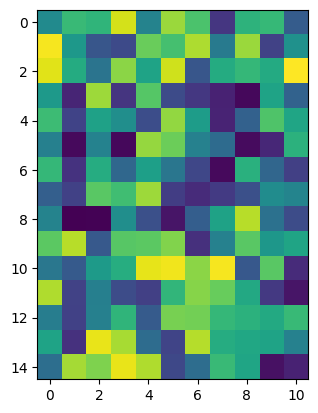

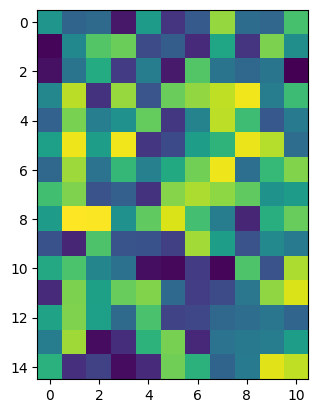

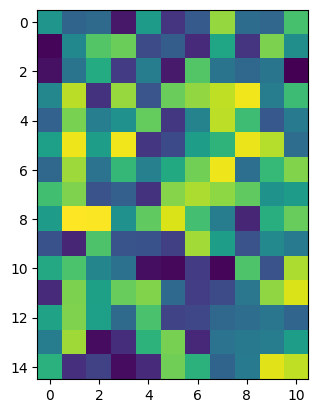

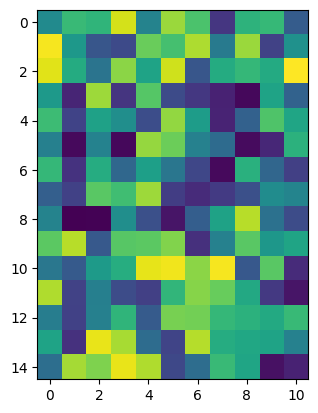

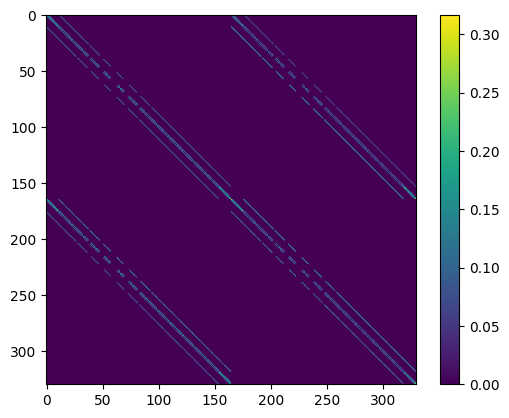

In [296]:
M = 2
O = 2
Lx = 11
Ly = 15
a_size = 4

np.random.seed(33)

pi = softmax( np.random.rand(O,M,M*a_size), 2)

PObs_lim = np.random.rand(O, M*Lx*Ly)
PObs_lim[1] = 1-PObs_lim[0]
Lx0 = Lx // 2
Ly0 = Ly // 3
rho0 = np.random.rand(M*Lx*Ly)
rho0[Lx:] = 0
rho0 /= np.sum(rho0)
eta0 = np.random.rand(M*Lx*Ly)
gamma = 0.95
find_range = 2.1
tol = 1e-8

# Solve eta
inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)
iter_sol = itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)
plt.imshow(T)
plt.colorbar()
plt.show()


RR_fortran shape: (2, 15, 11, 2, 4)


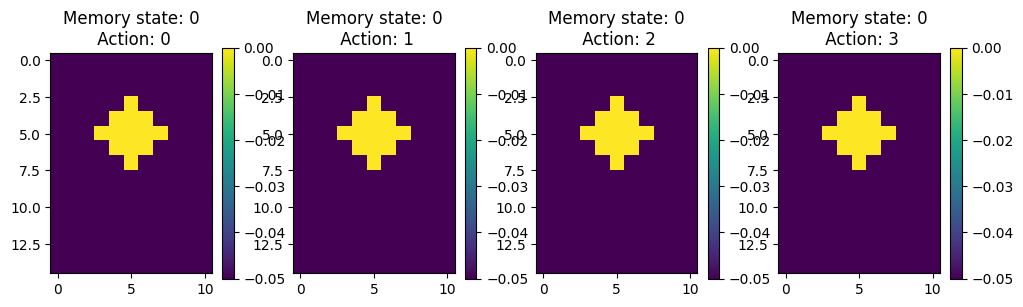

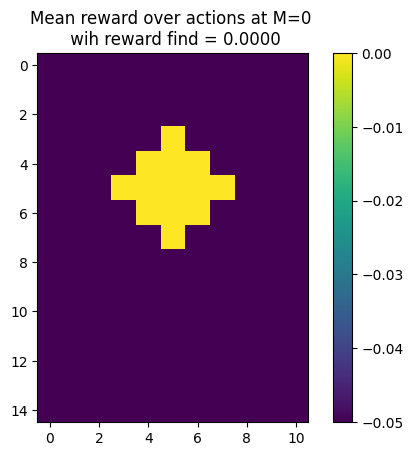

RR_Tsm_sm shape: (2, 15, 11)


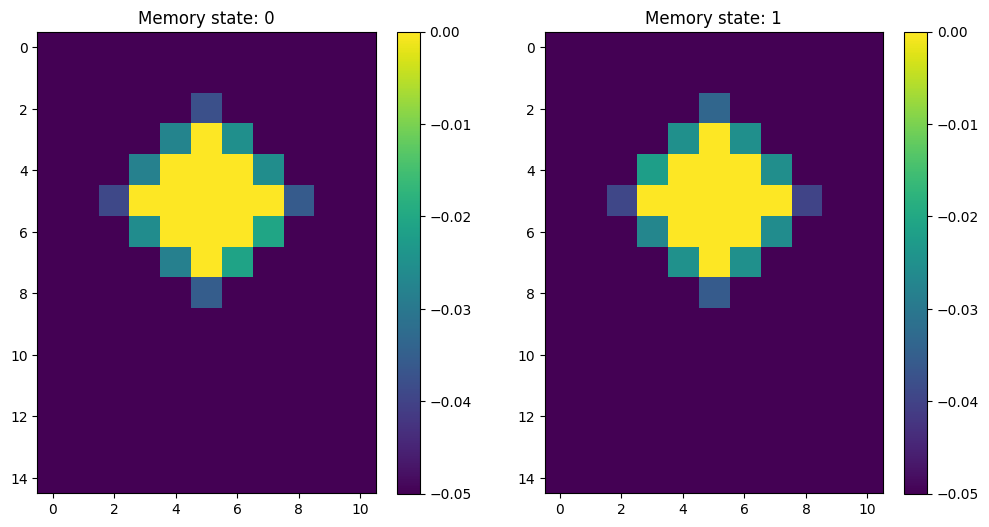

In [287]:

# Average reward
cost_move = 1-gamma
# reward_find = cost_move * 0.8
reward_find = 0.0

RR_fortran = average_reward(Lx, Ly, M, a_size, Lx0, Ly0, find_range,cost_move, reward_find)
RR_fortran_sel = RR_fortran[0,:,:,0,0] * 0.0
print('RR_fortran shape:', RR_fortran.shape)
fig = plt.figure(figsize=(12,3))
for i in range(a_size):
    plt.subplot(1,a_size,i+1)
    plt.title("Memory state: 0\n Action: "+str(i))
    plt.imshow(RR_fortran[0,:,:,0,i])
    plt.colorbar()
    RR_fortran_sel += RR_fortran[0,:,:,0,i]
plt.show()

plt.title("Mean reward over actions at M=0 \n wih reward find = {:.4f}".format(reward_find/a_size))
plt.imshow(RR_fortran_sel/a_size)
plt.colorbar()
plt.show()


RR_Tsm_sm = average_reward_2(T, M, Lx, Ly,cost_move)
print('RR_Tsm_sm shape:', RR_Tsm_sm.shape)
fig = plt.figure(figsize=(12,6))
for i in range(M):
    plt.subplot(1,M,i+1)
    plt.title("Memory state: "+str(i))
    plt.imshow(RR_Tsm_sm[i])
    plt.colorbar()
plt.show()


left
right
up
down
left
right
up
down
V shape (2, 15, 11)


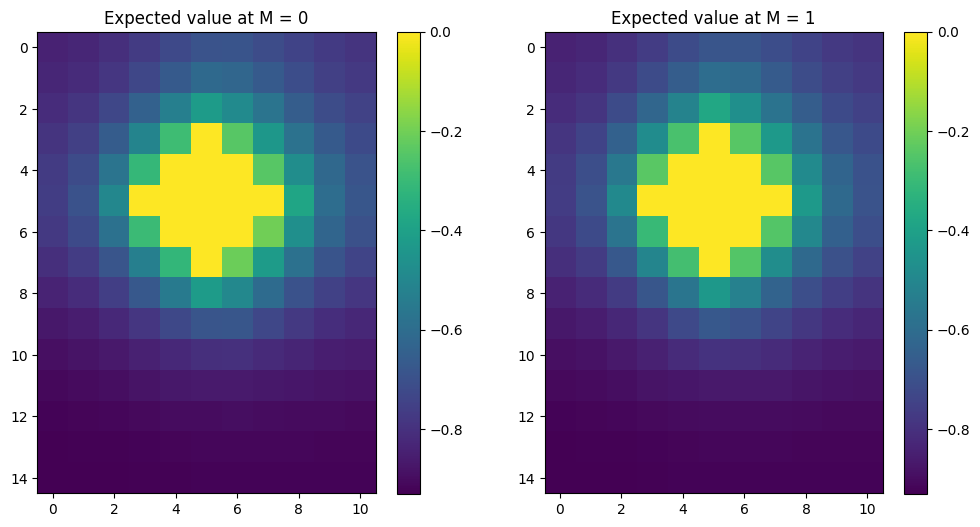

Diff between V in memory state 0 and 1 1.1794225327189207


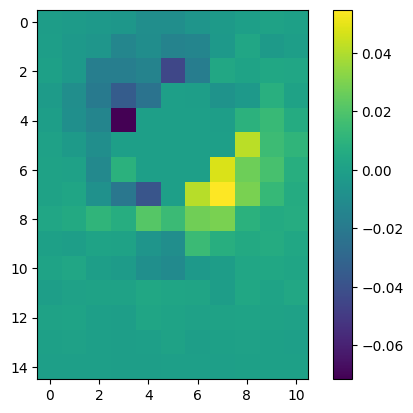

Q shape (2, 15, 11, 2, 4)


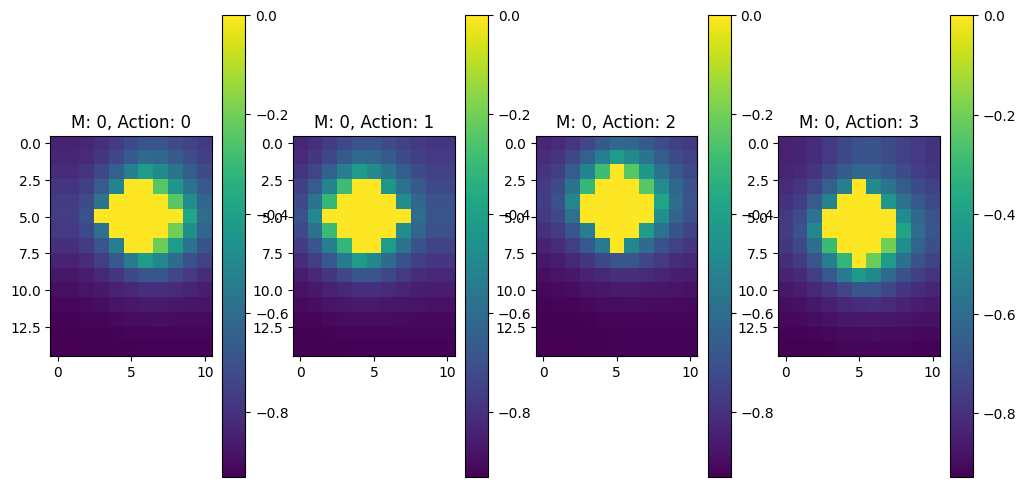

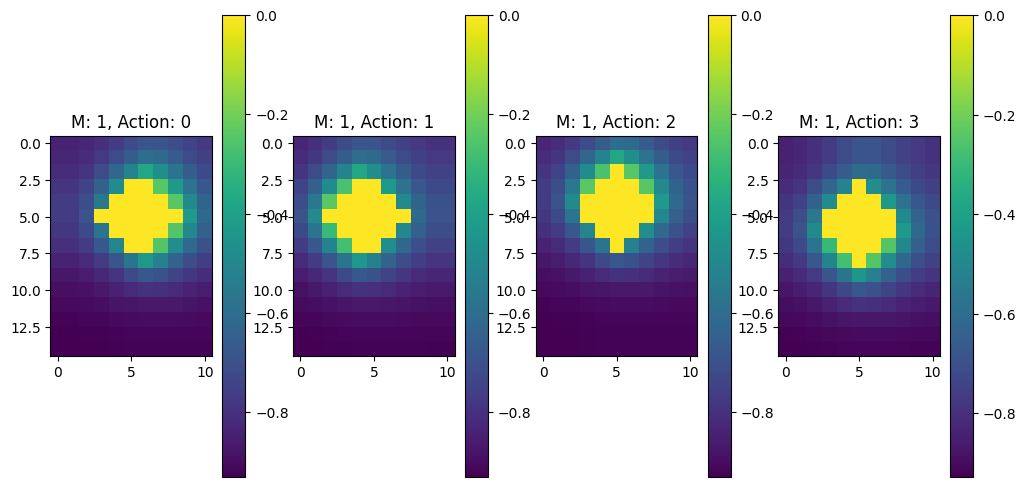

Diff between Q in memory state 0 and 1
Action: 0 0.987802130258173
Action: 1 1.0875908878785865
Action: 2 0.9914447198324015
Action: 3 1.0756227696930618


In [288]:

# Solve Q

V, Q = solve_Q(T, Lx, Ly, Lx0, Ly0, M, a_size, gamma, find_range)
print('V shape', V.shape)
fig = plt.figure(figsize=(12,6))
for i in range(M):
    plt.subplot(1,M,i+1)
    plt.title("Expected value at M = {}".format(i))
    plt.imshow(V[i,:,:])
    plt.colorbar()
plt.show()
# Diff between V in memory state 0 and 1
print("Diff between V in memory state 0 and 1", np.sum(np.abs(V[0,:,:]-V[1,:,:])))
plt.imshow(V[0,:,:]-V[1,:,:])
plt.colorbar()
plt.show()

print('Q shape', Q.shape)
for i in range(M):
    fig = plt.figure(figsize=(12,6))
    for j in range(a_size):
        plt.subplot(1,a_size,j+1)
        plt.title("M: {}, Action: {}".format(i,j))
        plt.imshow(Q[0,:,:,i,j])
        plt.colorbar()

    plt.show()

# Diff between Q in memory state 0 and 1
print("Diff between Q in memory state 0 and 1")
_ = [print("Action:",j,np.sum(np.abs(Q[0,:,:,0,j]-Q[0,:,:,1,j]))) for j in range(a_size)]



Q0 shape (2640,) M*a_size*M*Lx*Ly 2640
Q0_map shape:  (2, 15, 11, 2, 4)


/home/frodox/MHPC/Project/Finite-Memory-Controller/FSC/FSC_NB/../Comm/utils.py:33: RuntimeWarning: divide by zero encountered in divide
  random_Q0 = (-1/(1-gamma)*cost_move) / (1 + 2/np.abs(rr)) + (1 - 1/ (1 + 2/np.abs(rr)))*reward_find


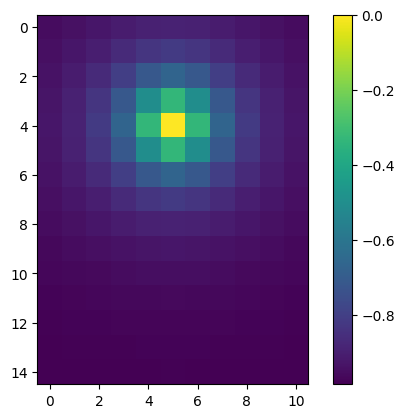

Q shape (2, 15, 11, 2, 4)


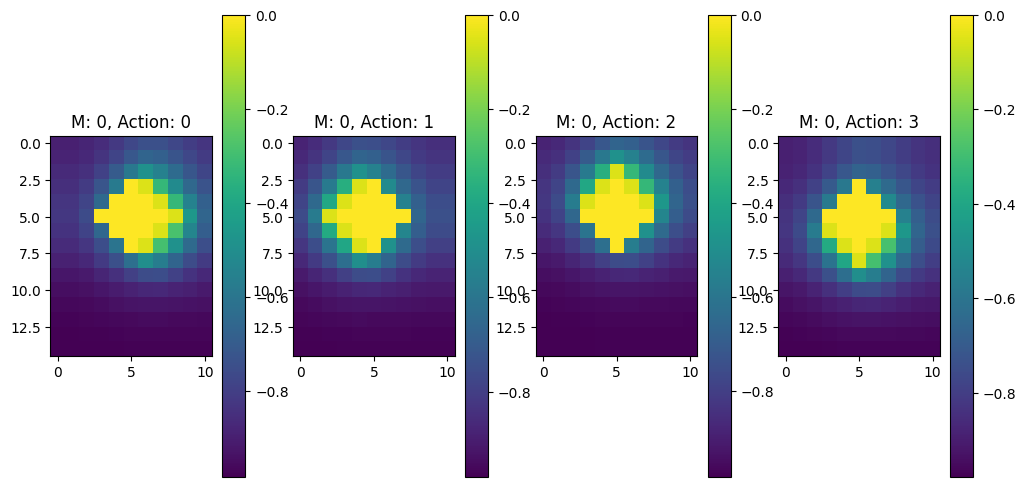

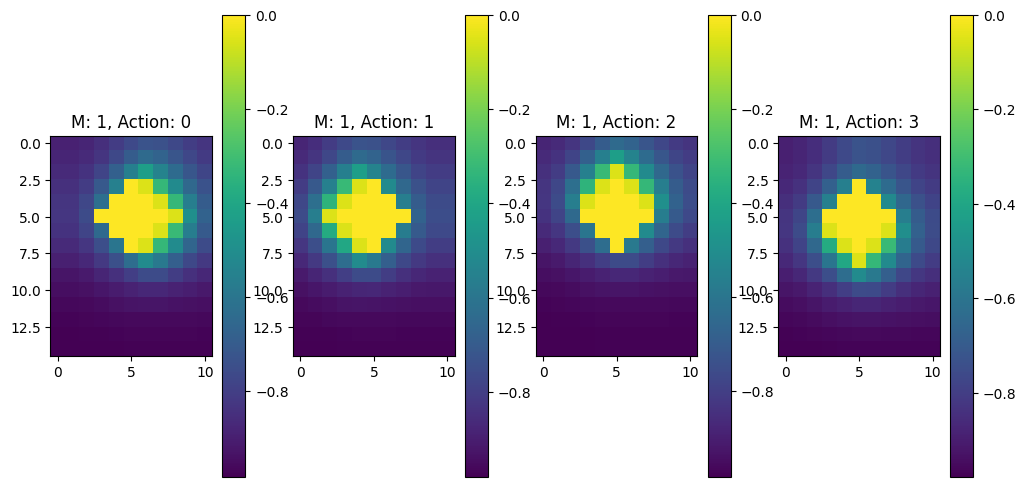

Diff between Q in memory state 0 and 1
Action: 0 0.8041855063802235
Action: 1 0.8743271477810957
Action: 2 0.8117877478235437
Action: 3 0.8452927390212147


In [289]:
Q0 = create_random_Q0(Lx, Ly, Lx0, Ly0, gamma,a_size*M, M, cost_move, reward_find)
print('Q0 shape', Q0.shape, "M*a_size*M*Lx*Ly", M*a_size*M*Lx*Ly)
Q0_map = Q0.reshape((M,Ly,Lx,M,a_size))
print("Q0_map shape: ", Q0_map.shape)
plt.imshow(Q0_map[0,:,:,0,0])
plt.colorbar()
plt.show()
# for i in range(M):
#     for k in range(M):
#         fig = plt.figure(figsize=(12,6))
#         for j in range(a_size):
#             plt.subplot(1,a_size,j+1)
#             plt.title("M: {}, M: {}, Action: {}".format(i,k,j))
#             plt.imshow(Q0_map[i,:,:,k,j])
#             plt.colorbar()
#         plt.show()  

Q0 = Q0.flatten()
RR_fortran = RR_fortran.flatten()
Q_fortran = itsolQ(pi, PObs_lim, gamma, RR_fortran, Q0, tol, Lx, Ly, Lx0, Ly0, find_range, cost_move)

Q_fortran = Q_fortran.reshape((M,Ly,Lx,M,a_size))

print('Q shape', Q_fortran.shape)
for i in range(M):
    fig = plt.figure(figsize=(12,6))
    for j in range(a_size):
        plt.subplot(1,a_size,j+1)
        plt.title("M: {}, Action: {}".format(i,j))
        plt.imshow(Q_fortran[0,:,:,i,j])
        plt.colorbar()

    plt.show()

# Diff between Q in memory state 0 and 1
print("Diff between Q in memory state 0 and 1")
_ = [print("Action:",j,np.sum(np.abs(Q_fortran[0,:,:,0,j]-Q_fortran[0,:,:,1,j]))) for j in range(a_size)]



Diff between Q fortran vs inverse
Memory state: 0, Action: 0, Diff: 8.874469510040349
    Inv min: -0.9307427885452613, max: 0.0
Fortran min: -0.9818157599181536, max: 0.0


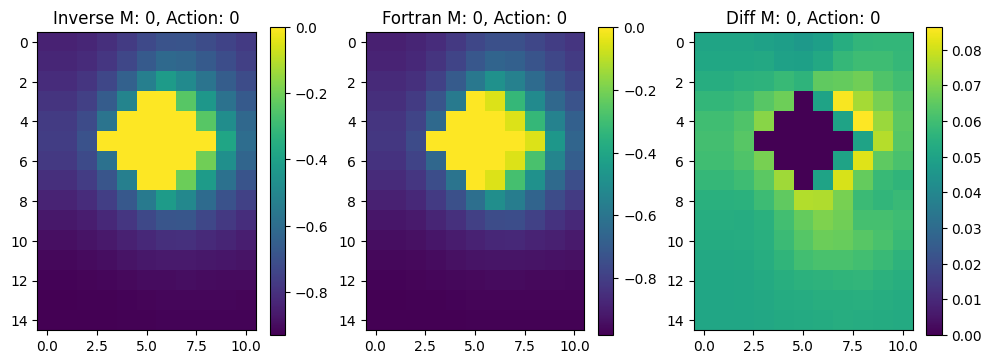

Memory state: 0, Action: 1, Diff: 8.925931507482842
    Inv min: -0.9300899090577603, max: 0.0
Fortran min: -0.9813241870237746, max: 0.0


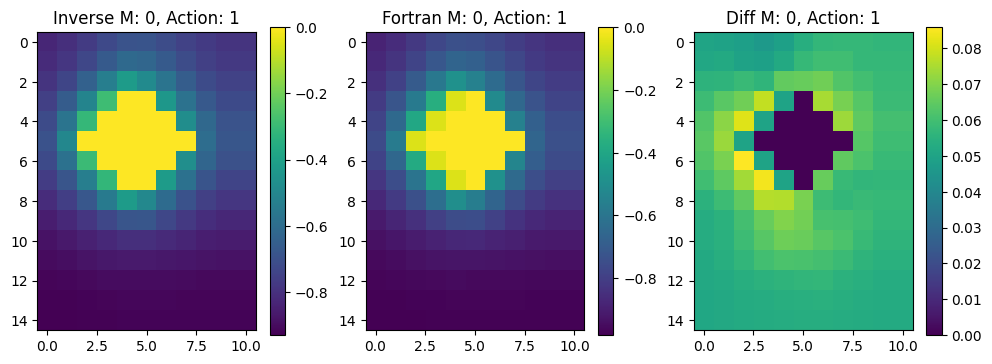

Memory state: 0, Action: 2, Diff: 8.901116779854984
    Inv min: -0.9307427885452613, max: 0.0
Fortran min: -0.9818157599181536, max: 0.0


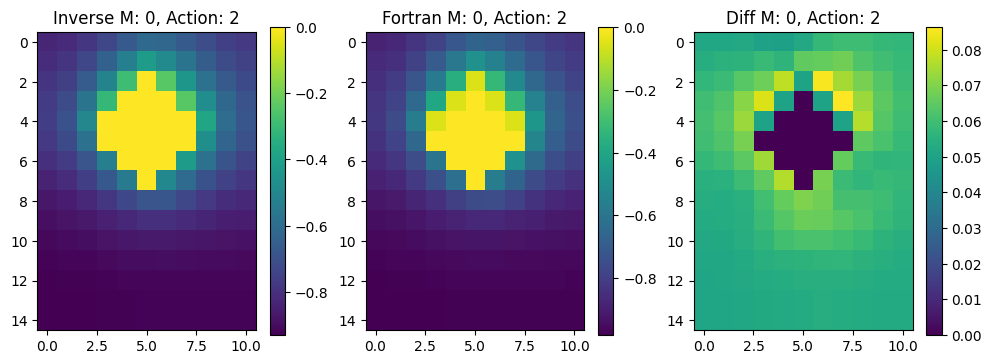

Memory state: 0, Action: 3, Diff: 8.907561797633445
    Inv min: -0.9275075372796938, max: 0.0
Fortran min: -0.9785391469917019, max: 0.0


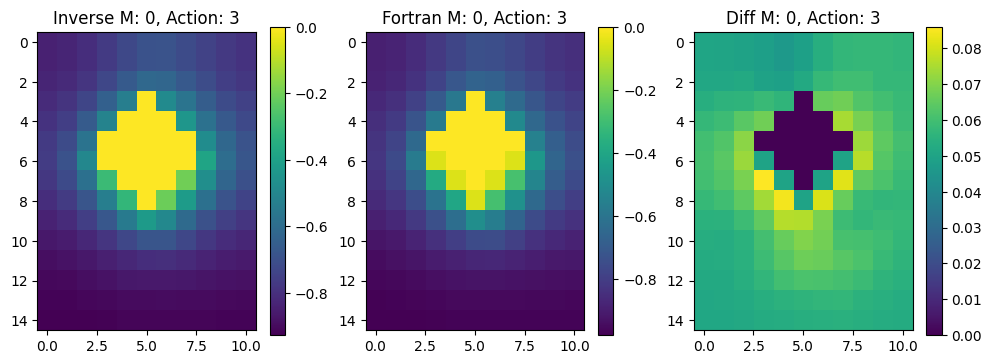

Memory state: 1, Action: 0, Diff: 8.830397188753249
    Inv min: -0.9307169123281664, max: 0.0
Fortran min: -0.9818055001614615, max: 0.0


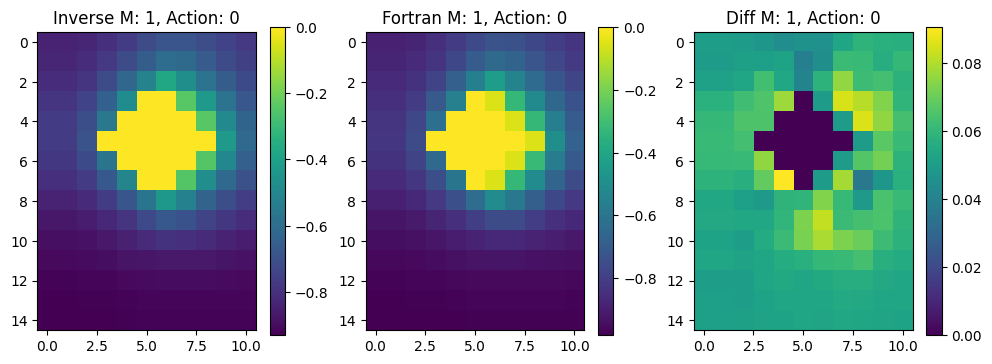

Memory state: 1, Action: 1, Diff: 8.908059587943562
    Inv min: -0.9298212384396972, max: 0.0
Fortran min: -0.9811967681496858, max: 0.0


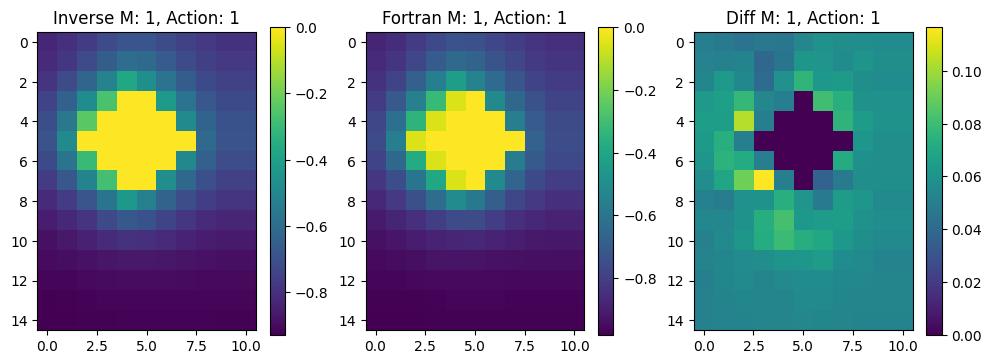

Memory state: 1, Action: 2, Diff: 8.873436863455314
    Inv min: -0.9307169123281664, max: 0.0
Fortran min: -0.9818055001614615, max: 0.0


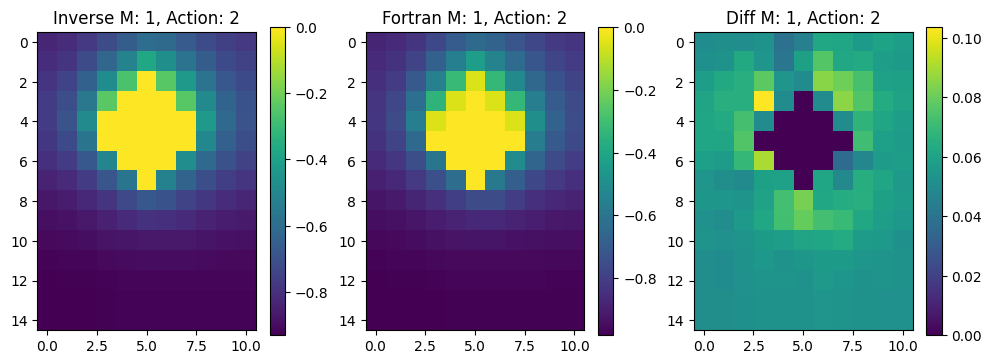

Memory state: 1, Action: 3, Diff: 8.873071058586568
    Inv min: -0.9276425289099847, max: 0.0
Fortran min: -0.9787672275265582, max: 0.0


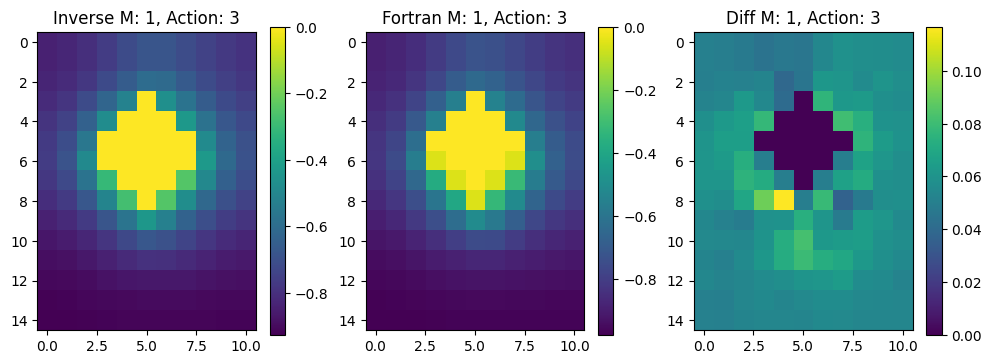

In [290]:
# Compare Q fortran vs inverse
print("Diff between Q fortran vs inverse")
for i in range(M):
    for j in range(a_size):
        print("Memory state: {}, Action: {}, Diff: {}".format(i,j,np.sum(np.abs(Q[0,:,:,i,j]-Q_fortran[0,:,:,i,j]))))
        print("    Inv min: {}, max: {}".format(np.min(Q[0,:,:,i,j]), np.max(Q[0,:,:,i,j])))
        print("Fortran min: {}, max: {}".format(np.min(Q_fortran[0,:,:,i,j]), np.max(Q_fortran[0,:,:,i,j])))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Inverse M: {}, Action: {}".format(i,j))
        plt.imshow(Q[0,:,:,i,j])
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.title("Fortran M: {}, Action: {}".format(i,j))
        plt.imshow(Q_fortran[0,:,:,i,j])
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.title("Diff M: {}, Action: {}".format(i,j))
        plt.imshow(Q[0,:,:,i,j]-Q_fortran[0,:,:,i,j])
        plt.colorbar()
        plt.show()


3.2571107011112547e-06


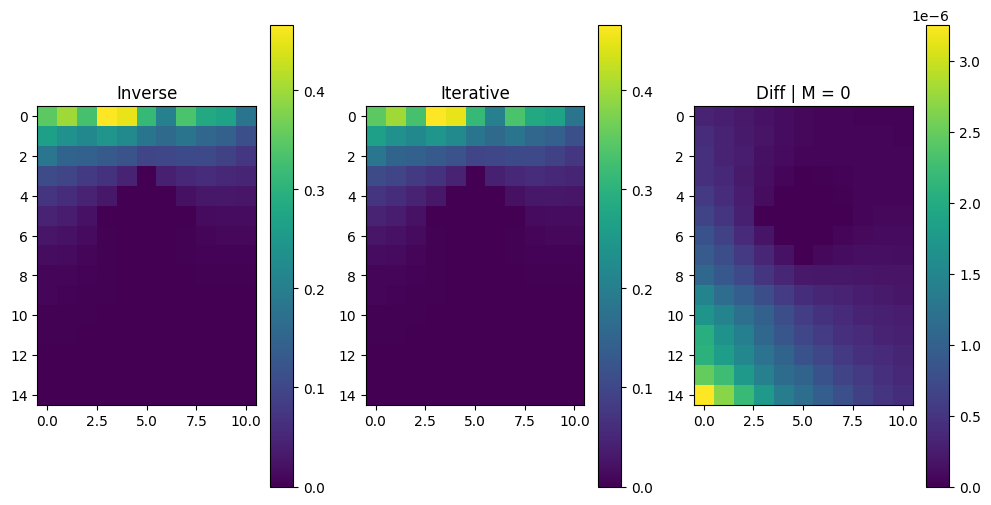

3.090643709345456e-06


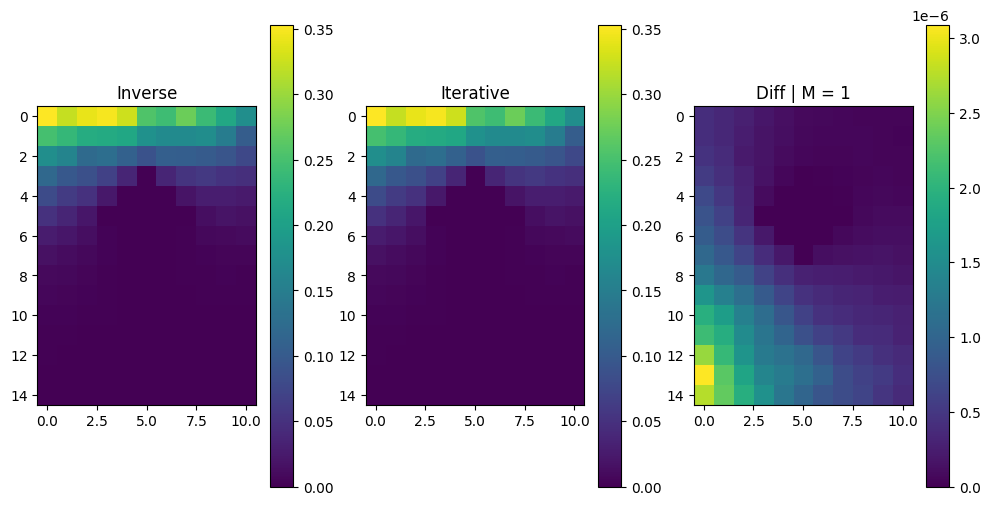

In [291]:
for im in range(M):
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.title("Inverse")
    plt.imshow(inv_sol.reshape(M,Ly,Lx)[im])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("Iterative")
    plt.imshow(iter_sol.reshape(M,Ly,Lx)[im])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Diff | M = {}".format(im))
    plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[im]-inv_sol.reshape(M,Ly,Lx)[im]))
    plt.colorbar()
    print(np.abs(iter_sol.reshape(M,Ly,Lx)[im]-inv_sol.reshape(M,Ly,Lx)[im]).max())
    

    plt.show()
